In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.scenarios.iv.base_iv import IVScenario
from simulation_engine.util.plotting_util import PlottingUtil
import pandas as pd
pd.set_option('display.max_columns', None)


#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data = BinaryIV.generate_data_rolling_ate(N_simulations=10)

# importr inside loop
#N = 10 -> 17s
#N = 50 -> 1m22s (outside: 18s)

In [7]:
binaryIV = BinaryIV('IV Dag', data)

# binaryIV.bound_ate_2SLS()
# binaryIV.bound_ate_causaloptim()
# binaryIV.bound_ate_autobound()
binaryIV.bound_ate_entropy()

Algorithm: autobound not found in dataframe columns.
Algorithm: causaloptim not found in dataframe columns.
Algorithm: 2SLS not found in dataframe columns.


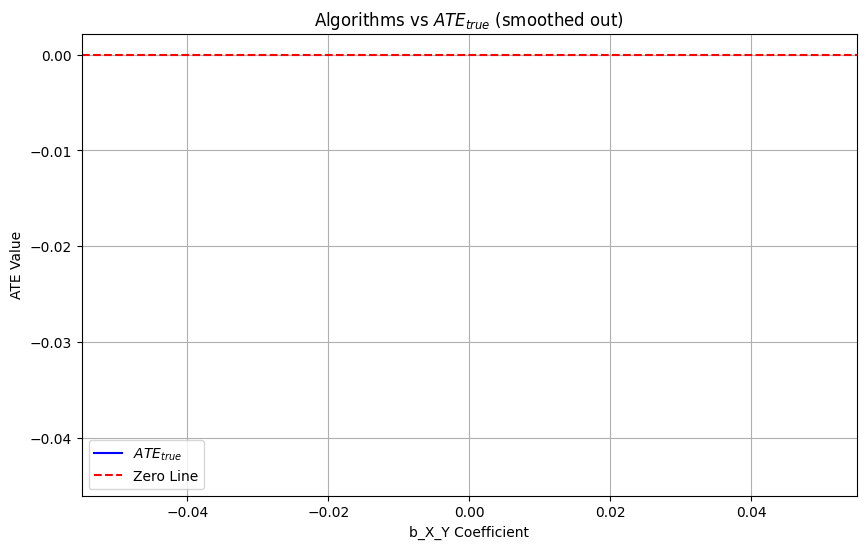

In [ ]:
binaryIV.data
algorithms = ['entropybounds']
PlottingUtil.print_bound_statistics(binaryIV.data, algorithms)
PlottingUtil.plot_smoothed_ate_vs_bounds(binaryIV.data, algorithms, 10)


In [ ]:
invalids = binaryIV.data[binaryIV.data['causaloptim_bound_valid'] == False]
invalids.mean(numeric_only=True)